In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Function to create a distribution of elements with fixed number of elements per bin
The ideia is that np.interp will interpolate a set of elements such that a fixed number of elements will be comprised in each interval of the interpolated function. <br>

We want a fixed number of objects per bin to compute the mean $\sigma_{nmad}$ per magnitude bin



In [2]:
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

### Reading photo-z training set table and plotting

In [8]:
training_set = pd.read_csv("Results_DF.csv", usecols=['r_aper_6', 'zml', 'z'])

In [9]:
rmag = training_set["r_aper_6"]
zml = training_set["zml"]
z = training_set["z"]

Text(0.5, 1.0, 'R_aper_6 histogram with fixed bin widths')

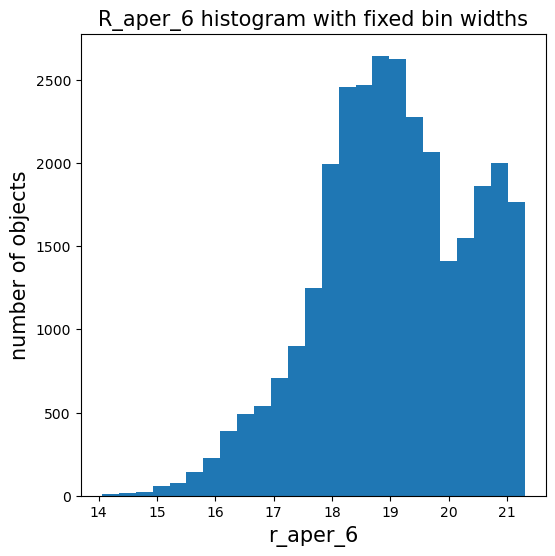

In [6]:
fontsize=15

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

ax.hist(rmag, 25, histtype='bar', rwidth=1.0)
ax.set_xlabel("r_aper_6", fontsize=fontsize)
ax.set_ylabel("number of objects", fontsize=fontsize)
ax.set_title("R_aper_6 histogram with fixed bin widths", fontsize=fontsize)

Text(0.5, 1.0, 'R_aper_6 histogram with fixed number of objects per bin')

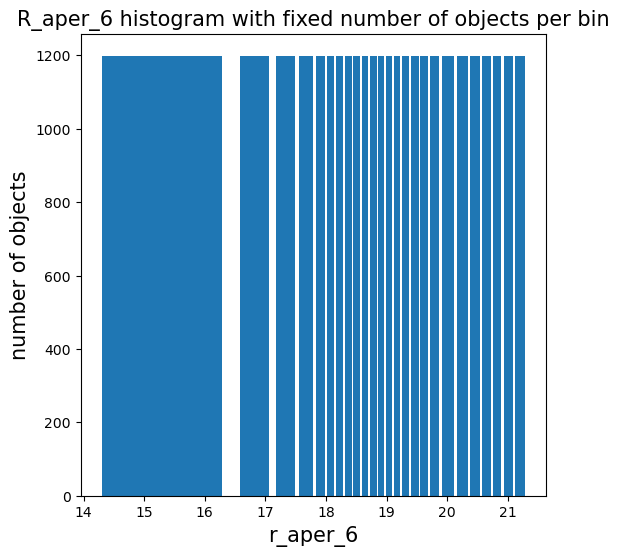

In [7]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)

n, bins, patches = ax.hist(rmag, histedges_equalN(rmag, 25), histtype='bar', rwidth=0.8)
ax.set_xlabel("r_aper_6", fontsize=fontsize)
ax.set_ylabel("number of objects", fontsize=fontsize)
ax.set_title("R_aper_6 histogram with fixed number of objects per bin", fontsize=fontsize)

### Calculating mean sigma_nmad's for each of those magnitude bins

In [10]:
mag = np.array(bins)
sigma_nmad = []
mag_bins = []

for i in range(1, len(mag), 1):
    mask = (rmag > mag[i-1]) & (rmag < mag[i])
    delta_z = zml[mask] - z[mask]
    sigma_nmad.append(np.abs(1.48 * np.median(abs(delta_z - np.median(delta_z)) / (1 + z[mask]))))
    mag_bins.append("{:.3f} <= r_mag <= {:.3f}".format(mag[i-1], mag[i]))

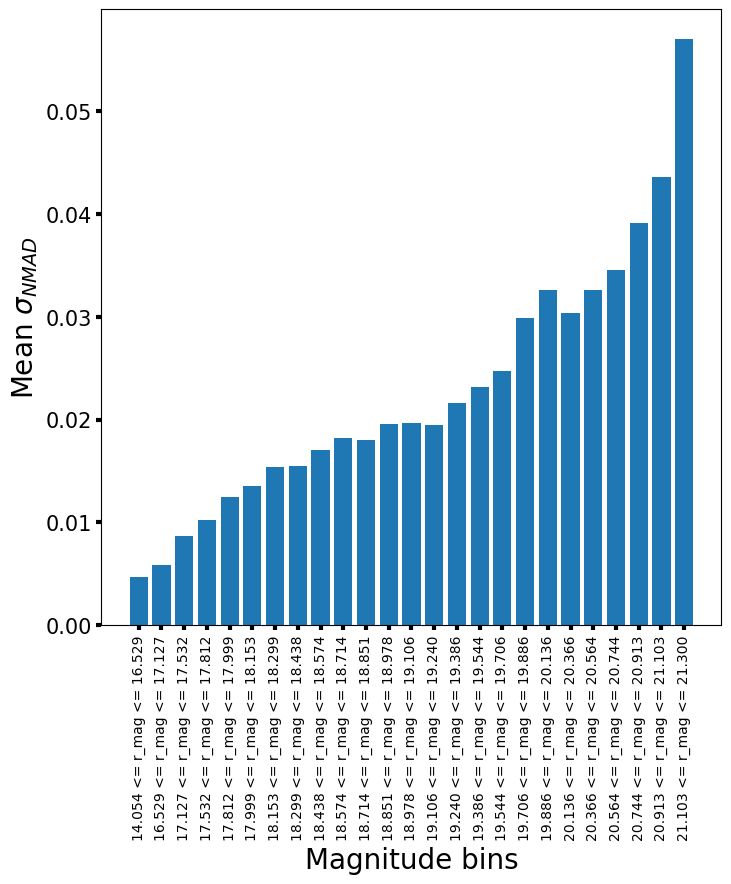

In [11]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.bar(mag_bins, sigma_nmad)
ax.set_xlabel("Magnitude bins", fontsize=20)
ax.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=20)
ax.xaxis.set_tick_params(labelsize=10, width=3, rotation=90)
ax.yaxis.set_tick_params(labelsize=15, width=3)

### Fit curve to the distribution of sigma_nmads

In [12]:
from scipy.optimize import curve_fit

In [13]:
def func1(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

In [14]:
#The bin (13, 2e-3) was added to extend the function down to r~13
sigma_nmad_new = np.concatenate((np.array([2e-3]), sigma_nmad))
mag_new = np.concatenate((np.array([13.00]), mag))

xdata = mag_new[:-1]
ydata = sigma_nmad_new

popt1, pcov1 = curve_fit(func1, xdata, ydata)

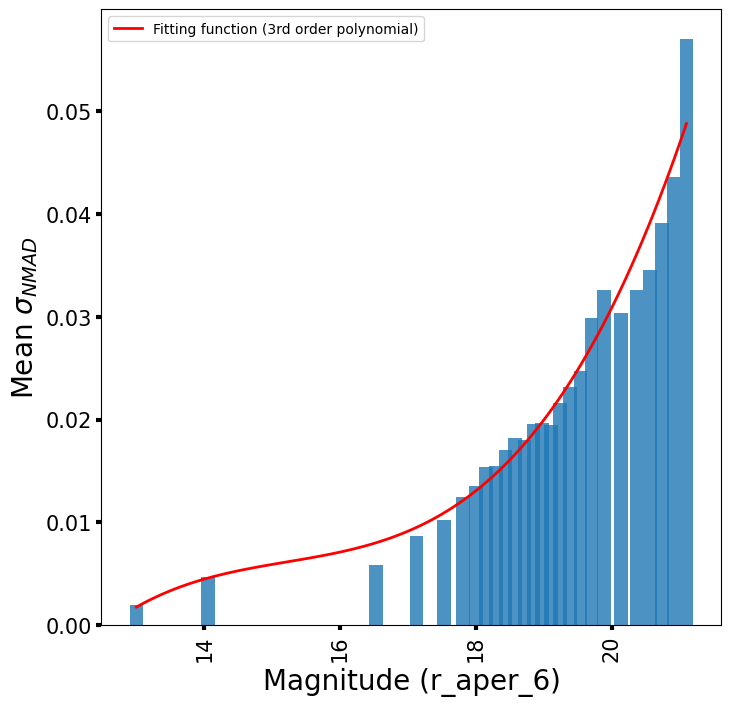

In [15]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

xnew = np.linspace(xdata[0], xdata[-1], 100)
# ax.scatter(xdata, ydata)
ax.bar(mag_new[:-1], sigma_nmad_new, alpha=0.8, width=0.2)
ax.plot(xnew, func1(xnew, *popt1), linewidth=2.0, color='red', label="Fitting function (3rd order polynomial)")
ax.set_xlabel("Magnitude (r_aper_6)", fontsize=20)
ax.set_ylabel(r"Mean $\sigma_{NMAD}$", fontsize=20)
ax.xaxis.set_tick_params(labelsize=15, width=3, rotation=90)
ax.yaxis.set_tick_params(labelsize=15, width=3)
ax.legend()

### Use the fitted function to perform the photo-z selection

#### 1. Targets from Legacy crossmatched with S-PLUS
Legacy: RMAG < 20.5; SG = 0; PRIMARY = 1 <br>
SPLUS: SEX_FLAGS_DET < 4 <br>
Crossmatch: 2 arcsecs

In [16]:
#Input the path to the table here
table_targets_path = "../Hydra-analysis/tables_photometric/Hydra-InSPLUS-AndLegacy.csv"

In [17]:
table_targets = pd.read_csv(table_targets_path, usecols=['OBJECT_ID', 'RA_J2000', 'Dec_J2000', 
                                                                             'zml', 'RFIBER', 'RMAG'])

In [19]:
objid =table_targets["OBJECT_ID"]
ra = table_targets["RA_J2000"]
dec = table_targets["Dec_J2000"]
zml = table_targets["zml"]
rfiber = table_targets["RFIBER"]
rmag = table_targets["RMAG"]

In [28]:
#Input here the redshift of the cluster (0.012 is the redshift of Hydra in this example):
z_cluster = 0.012

In [ ]:
dfs = []
n = 0
f = 5

for r in np.unique(rmag):   
#The idea here is to use the sigma_nmad function above r~16.5, and a constant value of sigma_nmad under r~16.5    
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
      
    if ((z_cluster - f*sigma_nmad) >= 0):
        mask = (rmag == r) & (zml > (z_cluster - (f*sigma_nmad))) & (zml < (z_cluster + (f*sigma_nmad)))
        
    elif ((z_cluster - f*sigma_nmad) < 0):
        mask = (rmag == r) & (zml > 0) & (zml < (z_cluster + (f*sigma_nmad)))

    n += np.sum(mask)
    print("Total number of objects: {:6d}".format(n))
    
    dfs.append(table_targets.loc[np.isin(objid, objid[mask])])
    
final_catalogue = pd.concat(dfs, ignore_index=True)

In [ ]:
#Save results to csv file
final_catalogue.to_csv("tables_photometric/CHANCES-catalogues/Hydra_Legacy_new8.csv", 
          columns=["OBJECT_ID", "RA_J2000",  "Dec_J2000", "zml", "RFIBER", "RMAG"], index=False)

### Compute photo-z selection completeness
The table needed to compute the completeness needs to have a column with the spectroscopic redshifts, for example "z" or whatever. It may be necessary to change the name of the column in the next cells accordingly. <br>

The following example if for the Hydra Cluster, but the selection of spectroscopic members have to be done manually for each individual cluster.


In [24]:
specz_table = pd.read_csv("../Hydra-analysis/tables_speczs/hydra_specz_InSPLUS-AndLegacy-crossmatch.csv", 
                    usecols=["RA_1", "DEC_1", "z_2", "zml", "RMAG"])

In [25]:
ra_sz = specz_table["RA_1"]
dec_sz = specz_table["DEC_1"]
z = specz_table["z_2"]
zml_sz = specz_table["zml"]
rmag_sz = specz_table["RMAG"]

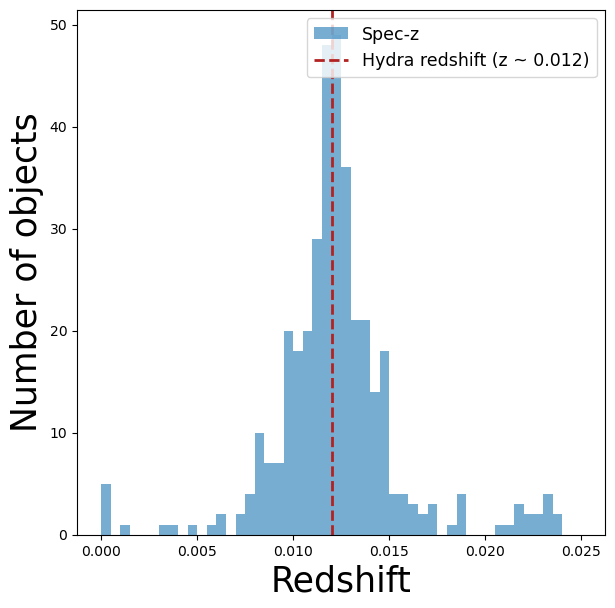

In [26]:
fontsize = 25
labelsize = 20

zmax = 0.025
mask_sz = (z > 0.0) & (z < zmax) 

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)

n, bins, patches = ax1.hist(z[mask_sz], alpha=0.6, label='Spec-z', bins=50, range=(0, zmax), histtype='stepfilled')
# ax1.set_title(r'PROB_GAL $ > $ {:.1f},'.format(pmin), fontsize=fontsize)
ax1.set_xlabel("Redshift", fontsize=fontsize)
ax1.set_ylabel("Number of objects", fontsize=fontsize)
ax1.axvline(x=0.012, linestyle='--', color='firebrick', linewidth=2.0, label='Hydra redshift (z ~ 0.012)')
# ax1.axvline(x=0.0165, linestyle='--', color='navy', linewidth=3.0)
ax1.legend(fontsize=fontsize*0.5)

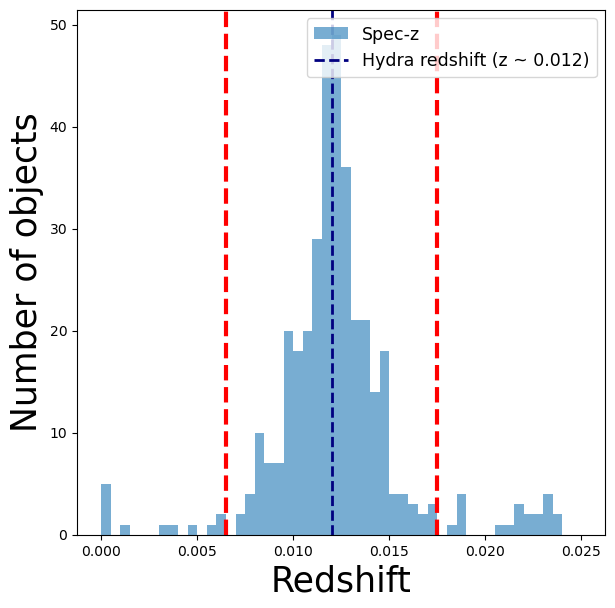

In [27]:
#Define the redshift interval for your cluster (by eye (?)) 
z_lower = 0.0065
z_upper = 0.0175

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)

n, bins, patches = ax1.hist(z[mask_sz], alpha=0.6, label='Spec-z', bins=50, range=(0, zmax), histtype='stepfilled')
# ax1.set_title(r'PROB_GAL $ > $ {:.1f},'.format(pmin), fontsize=fontsize)
ax1.set_xlabel("Redshift", fontsize=fontsize)
ax1.set_ylabel("Number of objects", fontsize=fontsize)
ax1.axvline(x=0.012, linestyle='--', color='navy', linewidth=2.0, label='Hydra redshift (z ~ 0.012)')
ax1.axvline(x=z_lower, linestyle='--', color='red', linewidth=3.0)
ax1.axvline(x=z_upper, linestyle='--', color='red', linewidth=3.0)
ax1.legend(fontsize=fontsize*0.5)

In [29]:
mask_hydra = (z > z_lower) & (z < z_upper) & (rmag_sz < 21.29)
galaxies_in_hydra = np.sum(mask_hydra)

#### Compute the photo-z selection again to see how many of the galaxies actually in Hydra are selected based on the photo-zs

In [31]:
selected_galaxies = 0
n = 0
f = 5

for r in np.unique(rmag_sz[mask_hydra]):   
    if (r > mag_new[:-1][2]): sigma_nmad = func1(r, *popt1)
    elif (r <= mag_new[:-1][2]): sigma_nmad = func1(mag_new[:-1][2], *popt1)
      
    if ((z_cluster - f*sigma_nmad) >= 0):
        mask = (rmag_sz[mask_hydra] == r) & (zml_sz[mask_hydra] > (z_cluster 
                                                - f*sigma_nmad)) & (zml_sz[mask_hydra] < (z_cluster + f*sigma_nmad))
        
    if ((z_cluster - f*sigma_nmad) < 0):
        mask = (rmag_sz[mask_hydra] == r) & (zml_sz[mask_hydra] > 0) & (zml_sz[mask_hydra] 
                                                < (z_cluster + f*sigma_nmad))

    n += np.sum(mask)
    print("Total number of objects: {:6d}".format(n))
    
    selected_galaxies += np.sum(mask)  

Total number of objects:      1
Total number of objects:      2
Total number of objects:      3
Total number of objects:      4
Total number of objects:      5
Total number of objects:      6
Total number of objects:      7
Total number of objects:      8
Total number of objects:      9
Total number of objects:     10
Total number of objects:     11
Total number of objects:     12
Total number of objects:     13
Total number of objects:     14
Total number of objects:     15
Total number of objects:     16
Total number of objects:     17
Total number of objects:     18
Total number of objects:     19
Total number of objects:     20
Total number of objects:     21
Total number of objects:     22
Total number of objects:     23
Total number of objects:     24
Total number of objects:     25
Total number of objects:     26
Total number of objects:     27
Total number of objects:     28
Total number of objects:     29
Total number of objects:     31
Total number of objects:     32
Total nu

Total number of objects:    286
Total number of objects:    286
Total number of objects:    287
Total number of objects:    288
Total number of objects:    289
Total number of objects:    290
Total number of objects:    291
Total number of objects:    292
Total number of objects:    293
Total number of objects:    294
Total number of objects:    295
Total number of objects:    296
Total number of objects:    297
Total number of objects:    298
Total number of objects:    299
Total number of objects:    299
Total number of objects:    300
Total number of objects:    301
Total number of objects:    302
Total number of objects:    303
Total number of objects:    304
Total number of objects:    305
Total number of objects:    306
Total number of objects:    307
Total number of objects:    308
Total number of objects:    309
Total number of objects:    310
Total number of objects:    311
Total number of objects:    312
Total number of objects:    313
Total number of objects:    314
Total nu

#### Compute the completeness of the selection

In [32]:
completeness = selected_galaxies / galaxies_in_hydra
print("completeness = {:.3f}".format(completeness))

completeness = 0.974


### 97,4% completeness